# Tutorial: Training a Voice Recognition Model¶

If you havent installed fastaudio do it uncommenting and executing the following cell

In [1]:
#!pip install git+https://github.com/fastaudio/fastaudio.git

In [2]:
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

from fastaudio.core.all import *
from fastaudio.augment.all import *

import torchaudio

In [3]:
p10speakers = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)

In [4]:
x = AudioGetter("", recurse=True, folders=None)
files_10  = x(p10speakers)
#original_aud = AudioItem.create(files[0])

## Datablock and Basic End to End Training on 10 Speakers¶

In [5]:
#crop 2s from the signal and turn it to a MelSpectrogram with no augmentation
cfg_voice = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg_voice)

In [6]:
auds = DataBlock(blocks=(AudioBlock.from_folder(p10speakers, crop_signal_to=2000), CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = a2s,
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [7]:
cats = [y for _,y in auds.datasets(p10speakers)]

In [8]:
#verify categories are being correctly assigned
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [9]:
dbunch = auds.dataloaders(p10speakers, bs=64)

<div class = "alert alert-block alert-info">Info:
Show batch is fixed now on nchannels, which is an object of AudioSpectrogram (part of sg settings but we overrode getattr to make it work like an attribute).</div>

/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


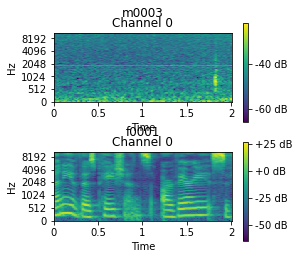

In [10]:
dbunch.show_batch(max_n=9)

In [11]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 251])

In [12]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [13]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0030199517495930195)

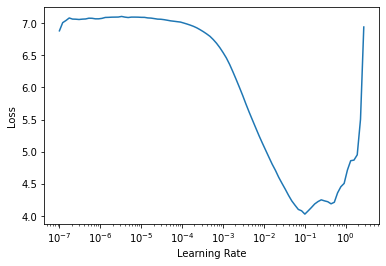

In [14]:
learn.lr_find()

In [15]:
#epochs are a bit longer due to the chosen melspectrogram settings
learn.fit_one_cycle(10, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.982005,1.652000,0.535156,00:06
1,0.813599,1.122795,0.726562,00:06
2,0.434651,1.328267,0.740885,00:06
3,0.266242,0.408208,0.839844,00:05
4,0.144300,0.181555,0.927083,00:06
5,0.082170,0.064481,0.979167,00:06
6,0.049960,0.847989,0.841146,00:06
7,0.033458,0.023514,0.994792,00:06
8,0.021735,0.016900,0.994792,00:05
9,0.015487,0.017779,0.996094,00:06
